![Zestimate](https://www.roundtablerealty.com/uploads/agent-1/699119.png)

# What is driving the errors in Zillow's Zestimates?
##### By: Jason R. Turner
##### For: *Zillow* Data Science Team
##### Date: June 20, 2022

In [1]:
# turn off pink warning boxes
import warnings
warnings.filterwarnings("ignore")

# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from math import sqrt
import os

from matplotlib import cm
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans

# wrangle and utility
import wrangle
import env
import util

<hr style="border-top: 12px groove royalblue; margin-top: 1px; margin-bottom: 1px"></hr>

## Project Goals
- To analyze the Zillow data set to see what's causing the difference between the predicted and actual sales price represented by logerror.
- Use machine learning models to help discover the best candidates for accounting for these differences in prediction
- Clearly explain the process and reasoning behind the steps taken to arrive at our conclusion

<hr style="border-top: 12px groove yellowgreen; margin-top: 1px; margin-bottom: 1px"></hr>

### - Project Objectives
> - Document code, process (data acquistion, preparation, exploratory data analysis and statistical testing, modeling, and model evaluation), findings, and key takeaways in a Jupyter Notebook report.
> - Create a module (wrangle.py) that make your process repeateable.
> - Construct a model to determine sources of estimate error using clustering techniques.
> - Deliver a 5 minute presentation consisting of a high-level notebook walkthrough using your Jupyter Notebook from above; your presentation should be appropriate for your target audience.
> - Answer panel questions about your code, process, findings and key takeaways, and model.

### - Business Goals
- To construct a ML clustering model that allows us to determine the drivers of error for Zillow Zestimates using 'logerror'.
- Document and present it a way that is clear and understandable

- Find the key sources of error for estimating the value of single family properties. Some questions that come to mind are:


- Deliver a report that the data science team can read through and replicate, understand what steps were taken, why and what the outcome was.

- Make recommendations on what works or doesn't work in prediction these homes' values.


### <font color='darkblue'>- Executive Summary</font>
- My initial ideas on what factors contributed to the discrepancy shown by log error did not pan out 
- I was able to figure out some of the features that do not have strong enough relationships to the Zestimate log error
- I can eliminate these as primary candidates for satisfactorily explaining the difference between predicted and actual home sale values.
- I theorize that we can get much stronger relationships by focusing on geographic data by breaking it down to be more granular to the neighborhood level to reflect local home values that both sellers and buyers use to determine what they'll list and pay for homes
- Future inquiries could try incorporating external data that could explain trends like recent changes in tax rates, changes in the local job market, or the health of the economy at large

#### Wrangle - acquire modules
- Called functions from my `wrangle.py` module for the acquire and prepare steps
- Used `get_connection` function to access data from the Codeup database by using credentials stored in my `env.py` file with the required user, host, and password information required for verification in conjucntion with the desired database name to create a unique url.
- Used `new_zillow_data` function to join the necessary tables to the 'properties_2017' table
- Used `get_zillow_data` to check if there's a locally cached .csv file and if not, to go fetch one from the database

In [2]:
# acquires data from SQL database if it's not already locally saved as a .csv 
# file and combines requested tables into a dataframe using wrangle module
z_df = wrangle.get_zillow_data()

#### Wrangle - prepare modules
- Dropped duplicate values keeping the most recent entry by sorting dataframe by 'transactiondate' and keep the last value using `drop_duplicates` function
- The missing values were addressed by determing how many null values there were
    - checked for nulls using `summarize` function from util.py file
- Any columns with more than 2% nulls were dropped using `percentage_dropper` from wrangle.py
- Checked to see what percentage of the data would remain after dropping all remaining rows with nulls, which was an acceptable 97%, and chose to drop them using `clean_zillow`, which also drops unneeded columns, converts some qualifying floats to integers, and date into datetime format
- Last we checked for any outliers using the `add_upper_outlier_columns` function to add columns for outliers above 1.5 times the interquartile range, which would keep 82% of the dataframe rows if removed, which I deemed acceptable
- Removed all rows containing outliers then removed the added columns for the outlier values

In [3]:
# sorted dataframe by transaction date
z_df = z_df.sort_values(by='transactiondate')

# drops all but the last duplicate row by parcelid
z_df = z_df.drop_duplicates(subset=['parcelid'], keep='last')

In [4]:
util.metrics(z_df)

There are 52320 rows and 63 columns in this dataframe.
Plus the following nulls:
propertylandusetypeid        0
parcelid                     0
id                           0
logerror                     0
transactiondate              0
                         ...  
taxamount                    4
taxdelinquencyflag       50252
taxdelinquencyyear       50252
censustractandblock        121
propertylandusedesc          0
Length: 63, dtype: int64


,count,mean,std,min,25%,50%,75%,max
propertylandusetypeid,52320.0,2.610000e+02,0.000000e+00,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02
parcelid,52320.0,1.299682e+07,3.350919e+06,1.071186e+07,1.151018e+07,1.257829e+07,1.413036e+07,1.676878e+08
id,52320.0,3.890428e+04,2.234519e+04,0.000000e+00,1.961425e+04,3.898450e+04,5.814150e+04,7.761300e+04
logerror,52320.0,1.813138e-02,1.769047e-01,-4.655420e+00,-2.470687e-02,6.934429e-03,4.059704e-02,5.262999e+00
id.1,52320.0,1.496906e+06,8.594330e+05,3.490000e+02,7.576135e+05,1.500134e+06,2.241333e+06,2.982270e+06
airconditioningtypeid,13615.0,2.439589e+00,3.847925e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,70.0,7.100000e+00,2.665670e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,47.0,6.789787e+02,7.118252e+02,3.800000e+01,2.635000e+02,5.120000e+02,8.095000e+02,3.560000e+03
bathroomcnt,52320.0,2.300010e+00,1.022807e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,52320.0,3.300765e+00,9.475551e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,1.400000e+01


In [5]:
# gets rid of any columns with more that 2% null values
z_df = wrangle.percentage_dropper(z_df)

In [6]:
# Groups our functions used to clean up our data into a single function for ease of use
z_df = wrangle.clean_zillow(z_df)

In [7]:
#Adds columns with the suffix _outliers for all the numeric columns in the given dataframe
wrangle.add_upper_outlier_columns(z_df, k=1.5)

,parcelid,logerror,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,...,lotsizesquarefeet_outliers,rawcensustractandblock_outliers,regionidcity_outliers,regionidzip_outliers,yearbuilt_outliers,structuretaxvaluedollarcnt_outliers,taxvaluedollarcnt_outliers,landtaxvaluedollarcnt_outliers,taxamount_outliers,censustractandblock_outliers
585,14297519,0.025595,2017-01-01,3.5,4,3100,6059,33634931.0,-117869207.0,4506,...,0.0,0.000000,0.0,0.0,0,47572.375,0.0,0.0,0.0,0.000000e+00
584,17052889,0.055619,2017-01-01,1.0,2,1465,6111,34449266.0,-119281531.0,12647,...,0.0,194960.798518,0.0,0.0,0,0.000,0.0,0.0,0.0,1.949638e+11
583,14186244,0.005383,2017-01-01,2.0,3,1243,6059,33886168.0,-117823170.0,8432,...,0.0,0.000000,0.0,0.0,0,0.000,0.0,0.0,0.0,0.000000e+00
582,12177905,-0.103410,2017-01-01,3.0,4,2376,6037,34245180.0,-118240722.0,13038,...,0.0,0.000000,314654.0,0.0,0,0.000,0.0,0.0,0.0,0.000000e+00
581,12095076,-0.001011,2017-01-01,3.0,4,2962,6037,34145202.0,-118179824.0,63000,...,49481.5,0.000000,0.0,0.0,0,0.000,0.0,0.0,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51815,11000655,0.020615,2017-09-20,2.0,2,1286,6037,34245368.0,-118282383.0,47405,...,33886.5,0.000000,0.0,0.0,0,0.000,0.0,0.0,0.0,0.000000e+00
51814,17239384,0.013209,2017-09-21,2.0,4,1612,6111,34300140.0,-118706327.0,12105,...,0.0,195034.797528,0.0,0.0,0,0.000,0.0,0.0,0.0,1.950378e+11
51813,12773139,0.037129,2017-09-21,1.0,3,1032,6037,34040895.0,-118038169.0,5074,...,0.0,0.000000,0.0,0.0,0,0.000,0.0,0.0,0.0,0.000000e+00
51812,12826780,0.007204,2017-09-25,2.0,3,1762,6037,33937685.0,-117996709.0,6347,...,0.0,0.000000,0.0,0.0,0,0.000,0.0,0.0,0.0,0.000000e+00


In [8]:
# drops rows for outliers in the outlier columns from dataframe
z_df.drop(z_df.index[z_df['bathroomcnt_outliers'] != 0], inplace=True)
z_df.drop(z_df.index[z_df['bedroomcnt_outliers'] != 0], inplace=True)
z_df.drop(z_df.index[z_df['calculatedfinishedsquarefeet_outliers'] != 0], inplace=True)
z_df.drop(z_df.index[z_df['lotsizesquarefeet_outliers'] != 0], inplace=True)
z_df.drop(z_df.index[z_df['structuretaxvaluedollarcnt_outliers'] != 0], inplace=True)
z_df.drop(z_df.index[z_df['taxvaluedollarcnt_outliers'] != 0], inplace=True)
z_df.drop(z_df.index[z_df['landtaxvaluedollarcnt_outliers'] != 0], inplace=True)
z_df.drop(z_df.index[z_df['taxamount_outliers'] != 0], inplace=True)


In [9]:
# drops columns that originally held the outliers
z_df = z_df.drop(['parcelid_outliers', 'logerror_outliers', 'fips_outliers', 'latitude_outliers', 'longitude_outliers', 'rawcensustractandblock_outliers', 'regionidcity_outliers', 'regionidzip_outliers', 'yearbuilt_outliers', 'bathroomcnt_outliers', 'censustractandblock_outliers', 'bedroomcnt_outliers', 'calculatedfinishedsquarefeet_outliers', 'lotsizesquarefeet_outliers', 'structuretaxvaluedollarcnt_outliers', 'taxvaluedollarcnt_outliers', 
'landtaxvaluedollarcnt_outliers', 'taxamount_outliers'], axis = 1)

<hr style="border-top: 12px groove royalblue; margin-top: 1px; margin-bottom: 1px"></hr>

### <font color='darkblue'>- Exploratory Analysis</font>

<hr style="border-top: 12px groove yellowgreen; margin-top: 1px; margin-bottom: 1px"></hr>

- Can we see patterns, find signals in the data?

- What features are driving the outcome?

- Are there other features we can construct that have stronger relationships?

- Use Visualization and statistical testing to help answer these questions

- We want to walk away from exploration with with modeling strategies (feature selection, algorithm selection, evaluation methods

#### Splitting Data
 - Split data for exploration into train, validate, and test at 48%, 32%, and 20% of original data set respectively

In [10]:
# splits test off, 20% of original df size, splits validate off 40% of what remains (32% of original df size)
train, validate, test = wrangle.split_zillow(z_df)
print("train observations: ", train.shape[0])
print("validate observations: ", validate.shape[0])
print("test observations: ", test.shape[0])

train observations:  19908
validate observations:  13272
test observations:  8296


#### Statistical Tests
- Showing the relationships between Log Error and various features to see if there's a strong enough correlation to be used as a feature after clustering.
- Looking for a positive or negative correlation of at least 40% for consideration
- α = 0.05

In [11]:
# set the alpha at a 95% confidence interval
α = 0.05

**Q1** - Is there a significant relationship between Bedroom Count and Log Error?
- $H_0$ : Null hypothesis - There's statistically significant relationship between the number of bedrooms and the Zestimate log error.
- $H_a$ : Alternative hypothesis - There's not a statistically significant relationship between the number of bedrooms and the Zestimate log error.

##### Scatter plot between Bedroom Count and Log Error

<Figure size 864x432 with 0 Axes>

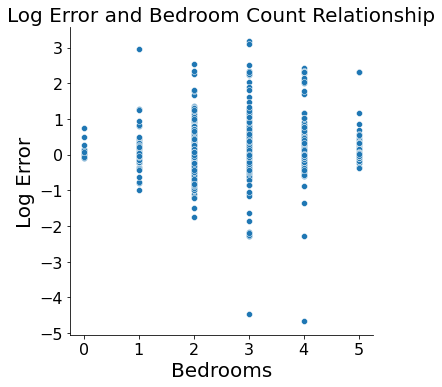

In [12]:
# set a larger figure size
plt.figure(figsize = (12,6))
# create a scatterplot
sns.relplot(data=train, x= 'bedroomcnt', y= 'logerror')
# make plot labels
plt.title('Log Error and Bedroom Count Relationship', fontsize = 20)
plt.xlabel('Bedrooms', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel('Log Error', fontsize = 20)

plt.show()

Pearson's R for Bedroom Count vs Logerror

In [13]:
# sets x & y values equal to churned bedroomcnt and logerror for correlation test
x = train.bedroomcnt
y = train.logerror

corr, p = stats.pearsonr(x, y)
corr, p

(0.020434634051143055, 0.003934584397033038)

In [14]:
# if statement to print out result of our null hypothesis
if p < α:
        print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

Reject the null hypothesis


**Q2** - Is there a significant relationship between Bathroom Count and Log Error?
- $H_0$ : Null hypothesis - There's statistically significant relationship between the number of bathrooms and the Zestimate log error.
- $H_a$ : Alternative hypothesis - There's not a statistically significant relationship between the number of bathrooms and the Zestimate log error.

##### Scatter plot between Bathroom Count and Log Error

<Figure size 864x432 with 0 Axes>

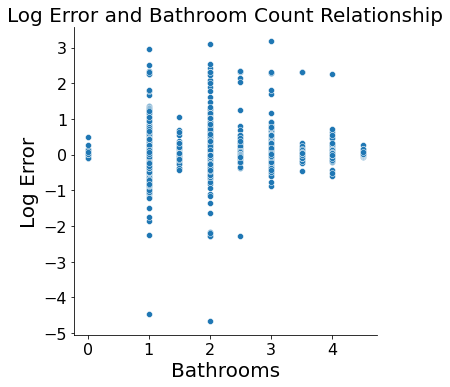

In [15]:
# set a larger figure size
plt.figure(figsize = (12,6))
# create a scatterplot
sns.relplot(data=train, x= 'bathroomcnt', y= 'logerror')
# make plot labels
plt.title('Log Error and Bathroom Count Relationship', fontsize = 20)
plt.xlabel('Bathrooms', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel('Log Error', fontsize = 20)

plt.show()

*Pearson's R* for Bathroom Count vs Logerror

In [16]:
# sets x & y values equal to churned bedroomcnt and logerror for correlation test
x = train.bathroomcnt
y = train.logerror

corr, p = stats.pearsonr(x, y)
corr, p

(0.009492317653646203, 0.18048233840583786)

In [17]:
# if statement to print out result of our null hypothesis
if p < α:
        print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

Fail to reject the null hypothesis


**Q3** - Is there a significant relationship between Home Area and Log Error?
- $H_0$ : Null hypothesis - There's statistically significant relationship between the home area ft$^2$ and the Zestimate log error.
- $H_a$ : Alternative hypothesis - There's not a statistically significant relationship between the home area ft$^2$ and the Zestimate log error.

##### Scatter plot between Home Area and Log Error

<Figure size 864x432 with 0 Axes>

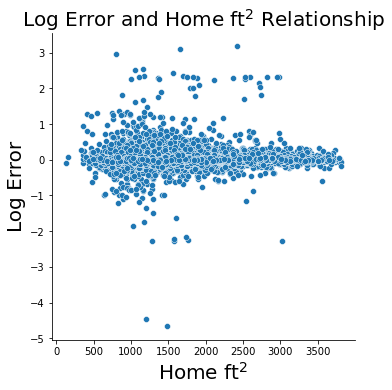

In [18]:
# set a larger figure size
plt.figure(figsize = (12,6))
# create a scatterplot
sns.relplot(data=train, x= 'calculatedfinishedsquarefeet', y= 'logerror')
# make plot labels
plt.title('Log Error and Home ft$^2$ Relationship', fontsize = 20)
plt.xlabel('Home ft$^2$', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.ylabel('Log Error', fontsize = 20)

plt.show()

*Pearson's R* for Home Area vs Logerror

In [19]:
# sets x & y values equal to churned bedroomcnt and logerror for correlation test
x = train.calculatedfinishedsquarefeet
y = train.logerror

corr, p = stats.pearsonr(x, y)
corr, p

(0.010315531165672139, 0.14555176524038793)

In [20]:
# if statement to print out result of our null hypothesis
if p < α:
        print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

Fail to reject the null hypothesis


**Q4** - Is there a significant relationship between Lot Area and Log Error?
- $H_0$ : Null hypothesis - There's statistically significant relationship between the lot area ft$^2$ and the Zestimate log error.
- $H_a$ : Alternative hypothesis - There's not a statistically significant relationship between the lot area ft$^2$ and the Zestimate log error.

##### Scatter plot between Lot Area and Log Error

<Figure size 864x432 with 0 Axes>

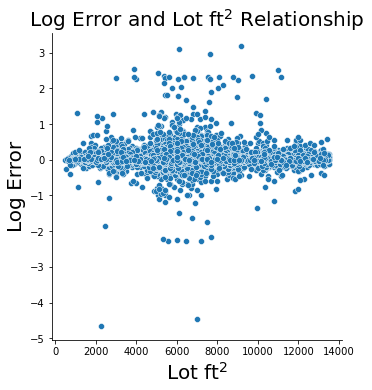

In [21]:
# set a larger figure size
plt.figure(figsize = (12,6))
# create a scatterplot
sns.relplot(data=train, x= 'lotsizesquarefeet', y= 'logerror')
# make plot labels
plt.title('Log Error and Lot ft$^2$ Relationship', fontsize = 20)
plt.xlabel('Lot ft$^2$', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.ylabel('Log Error', fontsize = 20)

plt.show()

*Pearson's R* for Lot Area vs Logerror

In [22]:
# sets x & y values equal to churned bedroomcnt and logerror for correlation test
x = train.lotsizesquarefeet
y = train.logerror

corr, p = stats.pearsonr(x, y)
corr, p

(0.00264559323794512, 0.7089556311881496)

In [23]:
# if statement to print out result of our null hypothesis
if p < α:
        print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

Fail to reject the null hypothesis


**Q5** - Is there a significant relationship between House Value and Log Error?
- $H_0$ : Null hypothesis - There's statistically significant relationship between the home value and the Zestimate log error.
- $H_a$ : Alternative hypothesis - There's not a statistically significant relationship between the home value and the Zestimate log error.

##### Scatter plot between House Value and Log Error

<Figure size 864x432 with 0 Axes>

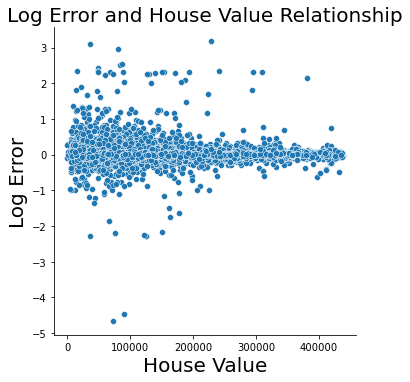

In [24]:
# set a larger figure size
plt.figure(figsize = (12,6))
# create a scatterplot
sns.relplot(data=train, x= 'structuretaxvaluedollarcnt', y= 'logerror')
# make plot labels
plt.title('Log Error and House Value Relationship', fontsize = 20)
plt.xlabel('House Value', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.ylabel('Log Error', fontsize = 20)

plt.show()

*Pearson's R* for House Value vs Logerror

In [25]:
# sets x & y values equal to churned bedroomcnt and logerror for correlation test
x = train.structuretaxvaluedollarcnt
y = train.logerror

corr, p = stats.pearsonr(x, y)
corr, p

(-0.027960603524912413, 7.958548545766259e-05)

In [26]:
# if statement to print out result of our null hypothesis
if p < α:
        print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

Reject the null hypothesis


#### Exploration Summary
- There's statistically significant results only for Bedroom Count and Home Value.  Bathroom Count, Home Area, and Lot Area did not show statistically signifcant results.
- However none of the relationships we tested for met the the target correlation criteria the strongest being a negative correlation with home value at a p-value of -0.028.
- Perhaps we can find stronger relationships amongst individual clusters once we break them out into the appropriate groups.


<hr style="border-top: 12px groove royalblue; margin-top: 1px; margin-bottom: 1px"></hr>

### <font color='darkblue'>- Modeling</font>


<hr style="border-top: 12px groove yellowgreen; margin-top: 1px; margin-bottom: 1px"></hr>

Scaling pertinent numerical columns that need to be scaled before modeling

In [27]:
# returns scaled data for select columns
scaled_train, scaled_validate, scaled_test = wrangle.scale_zillow(train, validate, test)

In [28]:
scaled_train

,parcelid,logerror,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,...,rawcensustractandblock,regionidcity,regionidzip,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,county
33328,14232282,-1.119136,2017-06-26,1.0,1.0,1.065020,6059,33797462.0,-117771172.0,-0.586280,...,6.059022e+07,33252,97067,1976,0.692638,1.132692,1.171637,0.960421,60590219172023,6059
43265,11476490,0.540171,2017-08-08,-2.0,-1.0,-0.439532,6037,33922895.0,-118417747.0,0.277375,...,6.037620e+07,55753,96103,1930,-0.175446,-0.264928,-0.157896,-0.375593,60376201023000,6037
17338,11310900,0.862361,2017-04-07,0.0,1.0,0.013004,6037,34673162.0,-118110949.0,0.266297,...,6.037901e+07,5534,97318,1989,0.212672,-0.433015,-0.508576,-0.300887,60379005042028,6037
17186,14215888,0.436501,2017-04-10,1.0,1.0,1.005202,6059,33844585.0,-117791456.0,1.101406,...,6.059022e+07,16764,97026,1976,0.689125,1.319841,1.396056,1.137003,60590219151022,6059
42808,17219739,-0.318161,2017-07-31,2.0,1.0,2.133940,6111,34224696.0,-118843259.0,0.518108,...,6.111008e+07,34278,96385,1982,2.456981,1.298931,0.686339,1.063754,61110075081000,6111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22104,13870707,0.029799,2017-05-05,2.0,2.0,0.457737,6059,33865943.0,-117950803.0,-0.201108,...,6.059002e+07,24812,97041,1955,-0.195774,0.174788,0.374066,0.107196,60590019021007,6059
39817,12294024,1.199022,2017-07-20,-2.0,-1.0,-0.923277,6037,33928420.0,-118193965.0,-0.214742,...,6.037540e+07,32616,96113,1948,-0.932112,-0.870475,-0.586533,-0.894549,60375401021005,6037
3746,11101113,-0.305284,2017-01-25,0.0,1.0,0.414824,6037,34225139.0,-118542002.0,0.051129,...,6.037115e+07,12447,96354,1975,0.139053,-0.321412,-0.347042,-0.354750,60371154041006,6037
14997,17108256,-0.420464,2017-04-03,0.0,0.0,-0.088427,6111,34277208.0,-119155953.0,-0.768641,...,6.111001e+07,34543,97084,1996,0.522502,0.495171,0.477692,0.283530,61110013013024,6111


### Clustering Exploration using KMeans
- I've used the Kmeans clustering machine learning model to make clusters that we hope will predict the logerror
- I've tried visualizing the inertia to determine a good number for k
- I've tried visualizing the clusters using scatterplots


In [29]:
# Using a seed to generate a random number that can be replicated for reproducibility
np.random.seed(42)

In [30]:
X = scaled_train[['logerror', 'bedroomcnt']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

kmeans.predict(X)

array([0, 0, 0, ..., 0, 0, 4], dtype=int32)

In [31]:
scaled_train['bedroom_cluster'] = kmeans.predict(X)

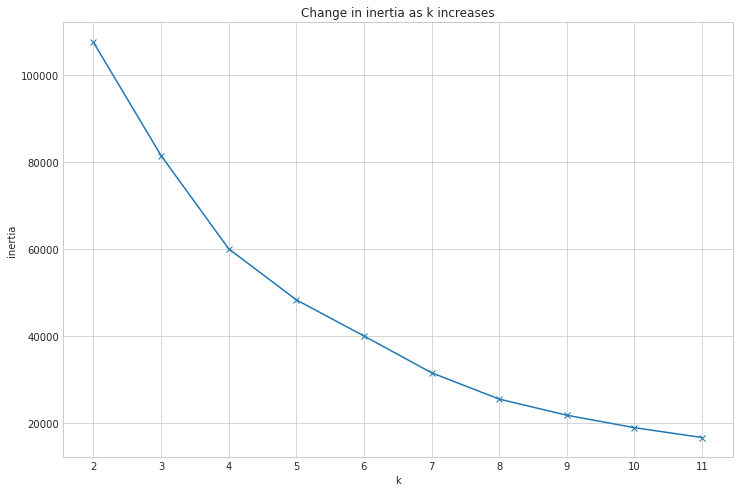

In [32]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(12, 8))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')


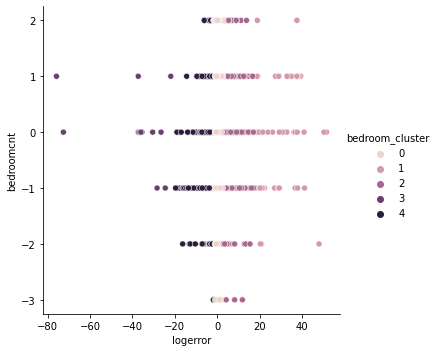

In [33]:
sns.relplot(data=scaled_train, x='logerror', y='bedroomcnt', hue='bedroom_cluster')

In [34]:
kmeans.cluster_centers_

array([[ 3.88336712e-02,  1.93327342e-01],
       [ 2.92916725e+01,  1.58730159e-02],
       [ 5.33018961e+00,  1.09343936e-02],
       [-3.84384499e+01,  7.69230769e-02],
       [-3.78512566e+00, -2.15264188e-01]])

In [35]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,logerror,bedroomcnt
0,0.038834,0.193327
1,29.291673,0.015873
2,5.330190,0.010934
3,-38.438450,0.076923
4,-3.785126,-0.215264


In [36]:
X = scaled_train[['logerror', 'bathroomcnt']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

kmeans.predict(X)

array([0, 2, 2, ..., 2, 2, 2], dtype=int32)

In [37]:
scaled_train['bathroom_cluster'] = kmeans.predict(X)

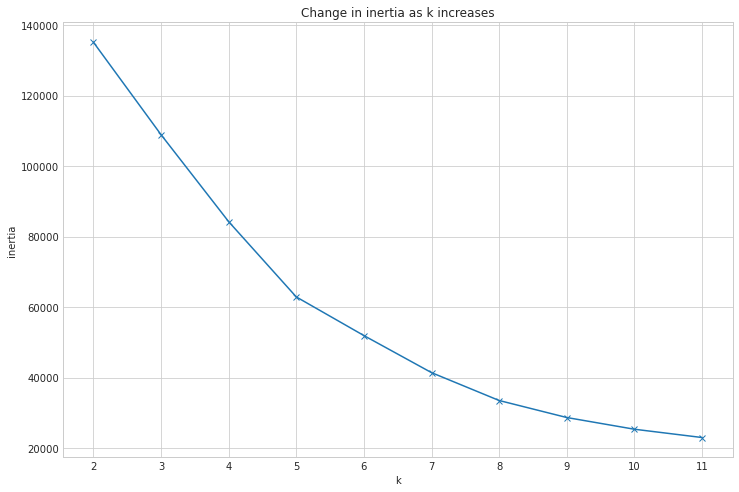

In [38]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(12, 8))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')


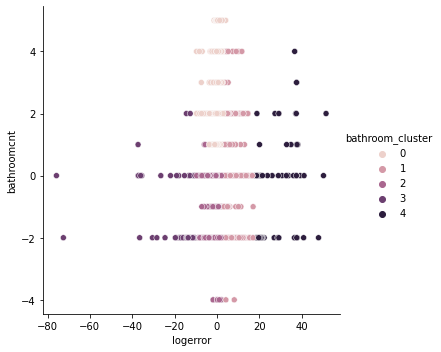

In [39]:
sns.relplot(data=scaled_train, x='logerror', y='bathroomcnt', hue='bathroom_cluster')

In [40]:
kmeans.cluster_centers_

array([[-7.85152896e-04,  1.86806412e+00],
       [ 5.35805289e+00, -4.25252525e-01],
       [-1.90413317e-01, -6.19312552e-01],
       [-1.95813116e+01, -1.28070175e+00],
       [ 2.92916725e+01, -2.53968254e-01]])

In [41]:
X = scaled_train[['logerror', 'calculatedfinishedsquarefeet']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

kmeans.predict(X)

array([0, 0, 0, ..., 0, 0, 4], dtype=int32)

In [42]:
scaled_train['homearea_cluster'] = kmeans.predict(X)

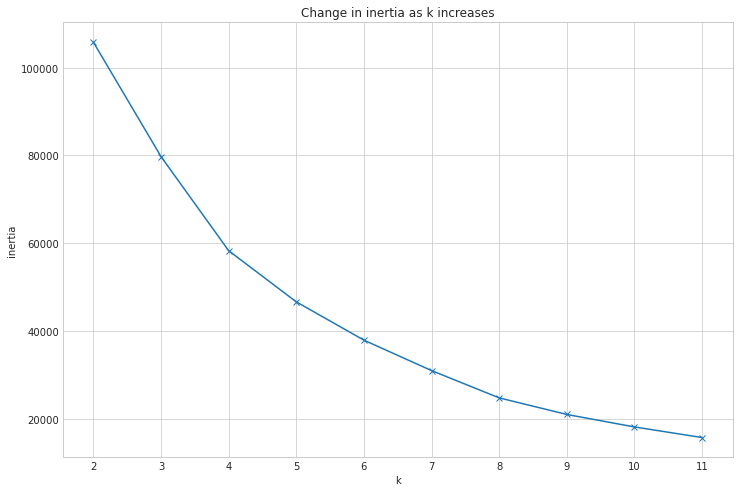

In [43]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(12, 8))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')


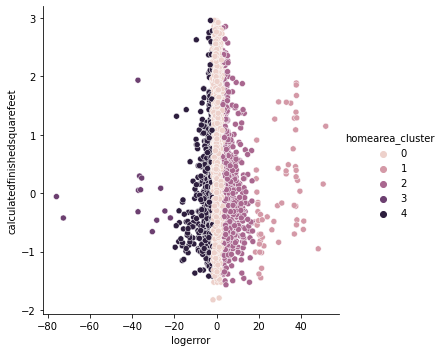

In [44]:
sns.relplot(data=scaled_train, x='logerror', y='calculatedfinishedsquarefeet', hue='homearea_cluster')

In [45]:
kmeans.cluster_centers_

array([[ 3.44226791e-02,  1.70875738e-01],
       [ 2.92916725e+01, -4.12822259e-05],
       [ 5.31725033e+00, -4.05204647e-02],
       [-3.84384499e+01,  3.30099030e-03],
       [-3.85457663e+00, -5.15175829e-02]])

In [46]:
X = scaled_train[['logerror', 'lotsizesquarefeet']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

kmeans.predict(X)

array([0, 0, 0, ..., 0, 0, 2], dtype=int32)

In [47]:
scaled_train['lotarea_cluster'] = kmeans.predict(X)

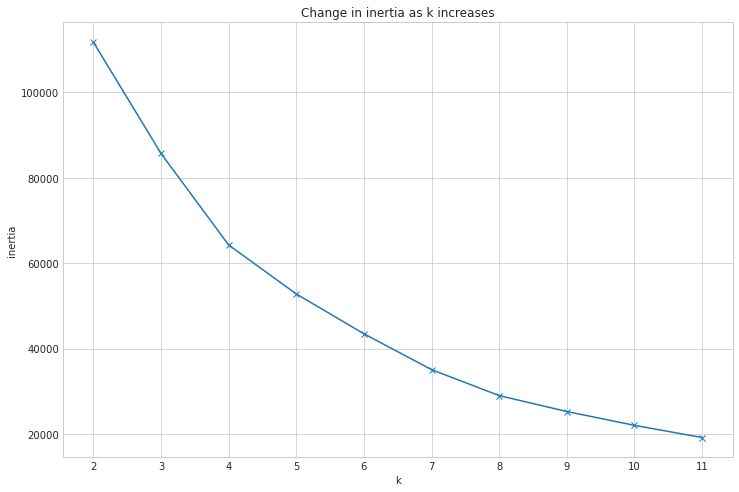

In [48]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(12, 8))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')


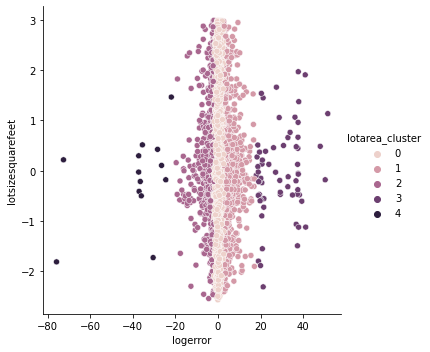

In [49]:
sns.relplot(data=scaled_train, x='logerror', y='lotsizesquarefeet', hue='lotarea_cluster')

In [50]:
kmeans.cluster_centers_

array([[ 4.33119414e-02,  6.15994243e-02],
       [ 5.33309098e+00,  7.49774773e-02],
       [-3.71731328e+00,  1.06639033e-01],
       [ 2.92916725e+01, -1.94101217e-02],
       [-3.84384499e+01, -1.41096654e-01]])

In [51]:
X = scaled_train[['logerror', 'structuretaxvaluedollarcnt']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

kmeans.predict(X)

array([3, 0, 0, ..., 0, 0, 3], dtype=int32)

In [52]:
scaled_train['hometax_cluster'] = kmeans.predict(X)

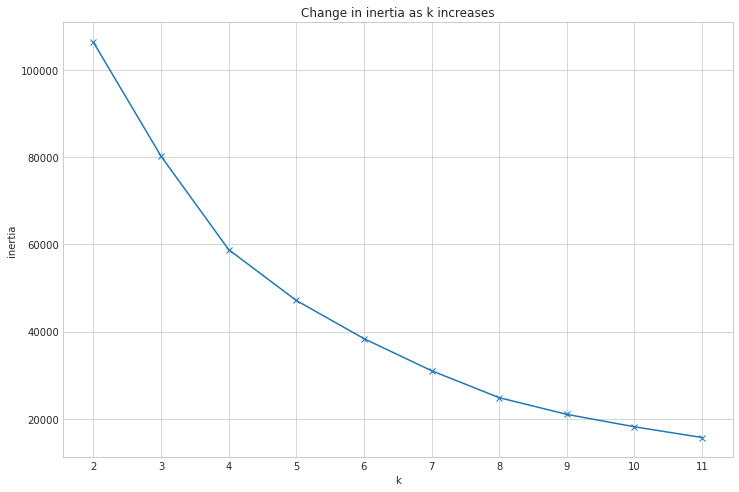

In [53]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(12, 8))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')


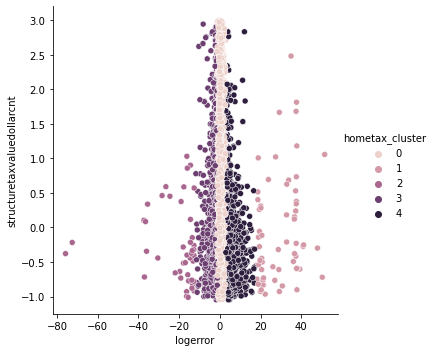

In [54]:
sns.relplot(data=scaled_train, x='logerror', y='structuretaxvaluedollarcnt', hue='hometax_cluster')

In [55]:
kmeans.cluster_centers_

array([[ 1.52761051e-01,  2.19799814e-01],
       [ 2.92916725e+01, -5.73693934e-02],
       [-2.18826795e+01, -2.39690162e-01],
       [-2.30091418e+00,  2.58442465e-02],
       [ 5.44031819e+00, -1.30637602e-01]])

In [56]:
scaled_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19908 entries, 33328 to 32959
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   parcelid                      19908 non-null  int64         
 1   logerror                      19908 non-null  float64       
 2   transactiondate               19908 non-null  datetime64[ns]
 3   bathroomcnt                   19908 non-null  float64       
 4   bedroomcnt                    19908 non-null  float64       
 5   calculatedfinishedsquarefeet  19908 non-null  float64       
 6   fips                          19908 non-null  int64         
 7   latitude                      19908 non-null  float64       
 8   longitude                     19908 non-null  float64       
 9   lotsizesquarefeet             19908 non-null  float64       
 10  propertycountylandusecode     19908 non-null  object        
 11  rawcensustractandblock  

In [57]:
scaled_train.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,19908.0,1.298278e+07,2.516619e+06,1.071188e+07,1.155290e+07,1.261307e+07,1.410735e+07,1.629608e+08
logerror,19908.0,1.773580e-01,2.752954e+00,-7.582382e+01,-4.926497e-01,7.054090e-18,5.073503e-01,5.155858e+01
bathroomcnt,19908.0,9.890496e-02,1.437680e+00,-4.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00
bedroomcnt,19908.0,1.624975e-01,8.241507e-01,-3.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00
calculatedfinishedsquarefeet,19908.0,1.484641e-01,7.685811e-01,-1.825748e+00,-4.135241e-01,0.000000e+00,5.864759e-01,2.960988e+00
fips,19908.0,6.049083e+03,2.094239e+01,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03
latitude,19908.0,3.401717e+07,2.676663e+05,3.334128e+07,3.382694e+07,3.399828e+07,3.418507e+07,3.471832e+07
longitude,19908.0,-1.181875e+08,3.496213e+05,-1.194484e+08,-1.183737e+08,-1.181408e+08,-1.179403e+08,-1.175723e+08
lotsizesquarefeet,19908.0,6.428645e-02,9.422109e-01,-2.564977e+00,-4.797614e-01,0.000000e+00,5.202386e-01,2.989348e+00
rawcensustractandblock,19908.0,6.049389e+07,2.078543e+05,6.037101e+07,6.037401e+07,6.037577e+07,6.059042e+07,6.111009e+07


### Regression Modeling

In [58]:
# splits our training set into x and y values to run in our algorithms
X_train_scaled = scaled_train.drop(columns=['logerror', 'parcelid', 'transactiondate', 'county', 'propertycountylandusecode', 'taxvaluedollarcnt', 'yearbuilt', 'censustractandblock', 'fips'])
y_train_scaled = scaled_train['logerror']

# splits our validate set into x and y values to run in our algorithms
X_validate_scaled = scaled_validate.drop(columns=['logerror', 'parcelid', 'transactiondate', 'county', 'propertycountylandusecode', 'taxvaluedollarcnt',  'yearbuilt', 'censustractandblock', 'fips'])
y_validate_scaled = scaled_validate['logerror']

                                         
# splits our test set into x and y values to run in our algorithms
X_test_scaled = scaled_test.drop(columns=['logerror', 'parcelid', 'transactiondate', 'county', 'propertycountylandusecode', 'taxvaluedollarcnt', 'yearbuilt', 'censustractandblock', 'fips'])
y_test_scaled = scaled_test['logerror']

##### Establishing Baseline

In [59]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train_scaled = pd.DataFrame(y_train_scaled)
y_validate_scaled = pd.DataFrame(y_validate_scaled)
y_test_scaled = pd.DataFrame(y_test_scaled)

# Predict logerror_pred_mean
train_logerror_pred_mean = y_train_scaled['logerror'].mean()
validate_logerror_pred_mean = y_validate_scaled['logerror'].mean()
test_logerror_pred_mean = y_test_scaled['logerror'].mean()
y_train_scaled['train_logerror_pred_mean'] = train_logerror_pred_mean
y_validate_scaled['validate_logerror_pred_mean'] = validate_logerror_pred_mean
y_test_scaled['test_logerror_pred_mean'] = test_logerror_pred_mean


# RMSE of logerror_pred_mean
rmse_train = mean_squared_error(y_train_scaled.logerror, y_train_scaled.train_logerror_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate_scaled.logerror, y_validate_scaled.validate_logerror_pred_mean)**(1/2)
rmse_test = mean_squared_error(y_test_scaled.logerror, y_test_scaled.test_logerror_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2),
      "\nTest/Out-of-Sample: ", round(rmse_test, 2))

df_baseline_eval = ((rmse_train*.48) + (rmse_validate*.32) + (rmse_test*.20))

print(f'RMSE Baseline is {df_baseline_eval}')


RMSE using Mean
Train/In-Sample:  2.75 
Validate/Out-of-Sample:  2.65 
Test/Out-of-Sample:  2.46
RMSE Baseline is 2.6591550952368426


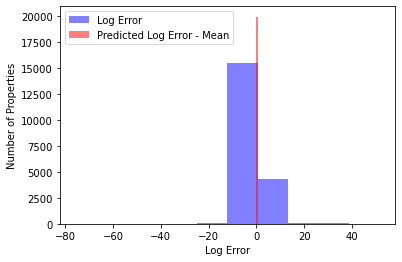

In [60]:
# plot to visualize actual vs predicted. 
plt.hist(y_train_scaled.logerror, color='blue', alpha=.5, label="Log Error")
plt.hist(y_train_scaled.train_logerror_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Log Error - Mean")
plt.xlabel("Log Error")
plt.ylabel("Number of Properties")
plt.legend()
plt.show()

#### Recursive Feature Elimination

In [61]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=3)

# fit the data using RFE
rfe.fit(X_train_scaled,y_train_scaled)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [62]:
rfe_feature

['bedroom_cluster', 'homearea_cluster', 'lotarea_cluster']

### Modeling Summary
- Clusters were created showing the best grouping with k = 5, however none of the relationships were strong enough to produce meaningful data to run linear regressions
- Recursive feature elimination did show us which of our relationships were too weak to consider for future investigation

<hr style="border-top: 12px groove royalblue; margin-top: 1px; margin-bottom: 1px"></hr>

### <font color='darkblue'>- Key Takeaways and Next Steps</font>

<hr style="border-top: 12px groove yellowgreen; margin-top: 1px; margin-bottom: 1px"></hr>

- The selected features don't have relationships strong enough to explain Zestimate log errors on their own.
- These can be eliminated as primary candidates for factors that satisfactorily explain the difference between predicted and actual home sale values by themselves.
- We can probably get much stronger relationships by focusing on geographic data breaking it down to the neighborhood level to reflect local home values that both sellers and buyers tend to use to determine what they'll list and pay for homes.
- In the future we can incorporate external sources that could show factors affecting home sale prices, like recent tax rates, local job market, or major changes in the economy.